In [1]:
# 忽略警告提示
import warnings
warnings.filterwarnings('ignore')

In [2]:
# 导入处理数据包
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

'''
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
'''

'\nfrom xgboost import XGBClassifier\nfrom sklearn.naive_bayes import GaussianNB\nfrom sklearn.model_selection import GridSearchCV\n'

In [3]:
# 导入数据
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

print('训练数据集：', train.shape, '测试数据集：', test.shape)

训练数据集： (891, 12) 测试数据集： (418, 11)


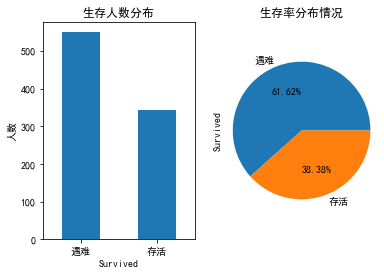

In [4]:
plt.rcParams['font.sans-serif'] = [u'SimHei']
plt.rcParams['axes.unicode_minus'] = False

surviveDf = train.groupby("Survived")['Survived'].count()
fig = plt.figure()
ax1 = fig.add_subplot(1, 2, 1)
surviveDf.plot(ax=ax1, kind='bar')
plt.ylabel("人数")
plt.title("生存人数分布")
plt.xticks(range(len(surviveDf)), ['遇难', '存活'], rotation=360)
ax2 = fig.add_subplot(1, 2, 2)
surviveDf.plot(ax=ax2, kind='pie', labels=['遇难', '存活'], autopct='%1.2f%%')
plt.axis("equal")
plt.title("生存率分布情况")
plt.show()

In [5]:
# 合并数据集，方便同时对两个数据集进行清洗
full = train.append(test, ignore_index=True)

print('合并后的数据集：', full.shape)

#full.head()  # 查看数据
#print(full.describe())
print(full.info())

合并后的数据集： (1309, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB
None


In [6]:
full.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [7]:
# 数据预处理
# 对于数据类型，处理缺失值最简单的方法就是用平均数来填充缺失值
full['Age'] = full['Age'].fillna(full['Age'].mean())
full['Fare'] = full['Fare'].fillna(full['Fare'].mean())

print(full['Embarked'].head())  # 缺失值较少
print(full['Embarked'].value_counts())
full['Embarked'] = full['Embarked'].fillna('S')
print(full['Cabin'].head())  # 缺失值较多，U表示未知
full['Cabin'] = full['Cabin'].fillna('U')

print(full.info())

0    S
1    C
2    S
3    S
4    S
Name: Embarked, dtype: object
S    914
C    270
Q    123
Name: Embarked, dtype: int64
0     NaN
1     C85
2     NaN
3    C123
4     NaN
Name: Cabin, dtype: object
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1309 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1309 non-null   float64
 10  Cabin        1309 non-null   object 
 11  Embarked     1309 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB
None


In [8]:
# 对分类数据处理：用数值代替类别，并进行One-hot编码
# 乘客性别（Sex）： 男性male，女性female
# 登船港口（Embarked）：出发地点S=英国南安普顿Southampton，途径地点1：C=法国 瑟堡市Cherbourg，出发地点2：Q=爱尔兰 昆士敦Queenstown
# 客舱等级（Pclass）：1=1等舱，2=2等舱，3=3等舱
sex_mapDict = {'male': 1, 'female': 0}
full['Sex'] = full['Sex'].map(sex_mapDict)

# 存放提取后的特征
embarkedDf = pd.DataFrame()
print(embarkedDf)
# one-hot编码，产生虚拟变量，列名前缀Embarked
embarkedDf = pd.get_dummies(full['Embarked'], prefix='Embarked')
print(embarkedDf.head())
full = pd.concat([full, embarkedDf], axis=1)
full.drop('Embarked', axis=1, inplace=True)  # Embarked由编码产生的虚拟变量代替

# 存放提取后的特征
pclassDf = pd.DataFrame()
# one-hot编码，产生虚拟变量，列名前缀Pclass
pclassDf = pd.get_dummies(full['Pclass'], prefix='Pclass')
full = pd.concat([full, pclassDf], axis=1)
full.drop('Pclass', axis=1, inplace=True)  # Pclass由编码产生的虚拟变量代替

Empty DataFrame
Columns: []
Index: []
   Embarked_C  Embarked_Q  Embarked_S
0           0           0           1
1           1           0           0
2           0           0           1
3           0           0           1
4           0           0           1


In [9]:
# 分类数据，字符串类型
# 从姓名中获取头衔
def getTitle(name):
    str1 = name.split(',')[1]  # Mr. Owen Harris
    str2 = str1.split('.')[0]  # Mr
    # strip()用于移除字符串头尾指定字符（默认为空格）
    str3 = str2.strip()
    return str3
# 存放提取后的特征
titleDf = pd.DataFrame()
# map函数：对Series每个数据应用自定义的函数计算
titleDf['Title'] = full['Name'].map(getTitle)
# 姓名中头衔字符串与定义头衔类别的映射关系
title_mapDict = {
    "Capt": "Officer",
    "Col": "Officer",
    "Major": "Officer",
    "Jonkheer": "Royalty",
    "Don": "Royalty",
    "Sir": "Royalty",
    "Dr": "Officer",
    "Rev": "Officer",
    "the Countess": "Royalty",
    "Dona": "Royalty",
    "Mme": "Mrs",
    "Mlle": "Miss",
    "Ms": "Mrs",
    "Mr": "Mr",
    "Mrs": "Mrs",
    "Miss": "Miss",
    "Master": "Master",
    "Lady": "Royalty"
}
# map函数：对Series每个数据应用自定义的函数计算
titleDf['Title'] = titleDf['Title'].map(title_mapDict)
# 进行one-hot编码
titleDf = pd.get_dummies(titleDf['Title'])
full = pd.concat([full, titleDf], axis=1)
full.drop('Name', axis=1, inplace=True)

# 存放客舱号信息
cabinDf = pd.DataFrame()
full['Cabin'] = full['Cabin'].map(lambda c: c[0])
cabinDf = pd.get_dummies(full['Cabin'], prefix='Cabin')
full = pd.concat([full, cabinDf], axis=1)
full.drop('Cabin', axis=1, inplace=True)

# 存放家庭信息
familyDf = pd.DataFrame()
familyDf['FamilySize'] = full['Parch'] + full['SibSp'] + 1
# if条件为真的时候返回if前面内容，否则返回0
familyDf['Family_Small'] = familyDf['FamilySize'].map(lambda s: 1 if s == 1 else 0)
familyDf['Family_Medium'] = familyDf['FamilySize'].map(lambda s: 1 if 2 <= s <= 4 else 0)
familyDf['Family_Large'] = familyDf['FamilySize'].map(lambda s: 1 if 5 <= s else 0)
full = pd.concat([full, familyDf], axis=1)

print(full.shape)

(1309, 33)


In [10]:
titleDf.head()

,Master,Miss,Mr,Mrs,Officer,Royalty
0,0,0,1,0,0,0
1,0,0,0,1,0,0
2,0,1,0,0,0,0
3,0,0,0,1,0,0
4,0,0,1,0,0,0


               PassengerId  Survived       Sex       Age     SibSp     Parch  \
PassengerId       1.000000 -0.005007  0.013406  0.025731 -0.055224  0.008942   
Survived         -0.005007  1.000000 -0.543351 -0.070323 -0.035322  0.081629   
Sex               0.013406 -0.543351  1.000000  0.057397 -0.109609 -0.213125   
Age               0.025731 -0.070323  0.057397  1.000000 -0.190747 -0.130872   
SibSp            -0.055224 -0.035322 -0.109609 -0.190747  1.000000  0.373587   
Parch             0.008942  0.081629 -0.213125 -0.130872  0.373587  1.000000   
Fare              0.031416  0.257307 -0.185484  0.171521  0.160224  0.221522   
Embarked_C        0.048101  0.168240 -0.066564  0.076179 -0.048396 -0.008635   
Embarked_Q        0.011585  0.003650 -0.088651 -0.012718 -0.048678 -0.100943   
Embarked_S       -0.049836 -0.149683  0.115193 -0.059153  0.073709  0.071881   
Pclass_1          0.026495  0.285904 -0.107371  0.362587 -0.034256 -0.013033   
Pclass_2          0.022714  0.093349 -0.

Name: Survived, dtype: float64


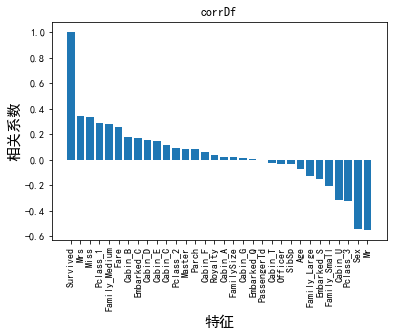

In [11]:
# 相关系数：计算各个特征的相关系数
corrDf = full.corr()
print(corrDf)
# 查看各个特征与Survived的相关系数，ascending=False表示按降序排列
plt_corrDf = corrDf['Survived'].sort_values(ascending=False)
print(plt_corrDf)

plt.figure()
plt.title("corrDf")
plt.bar(range(len(plt_corrDf)), plt_corrDf)
plt.xticks(range(len(plt_corrDf)), plt_corrDf.keys(), rotation='vertical')
plt.xlabel("特征",fontsize=15)
plt.ylabel("相关系数",fontsize=15)
plt.show()

In [12]:
# 特征选择
full_x = pd.concat([titleDf,  # 头衔
                    pclassDf,  # 客舱等级
                    familyDf,  # 家庭大小
                    full['Fare'],  # 船票价格
                    cabinDf,  # 船舱号
                    embarkedDf,  # 登船港口
                    full['Sex']  # 性别
                    ], axis=1)
print("特征选择：", full_x.shape)

特征选择： (1309, 27)


Survived
0.0    22.696673
1.0    48.537330
Name: Fare, dtype: float64
level          ≤10     10-30     30-50    50-100     100以上
Survived                                                  
遇难        0.794393  0.566978  0.635135  0.345794  0.264151
存活        0.205607  0.433022  0.364865  0.654206  0.735849


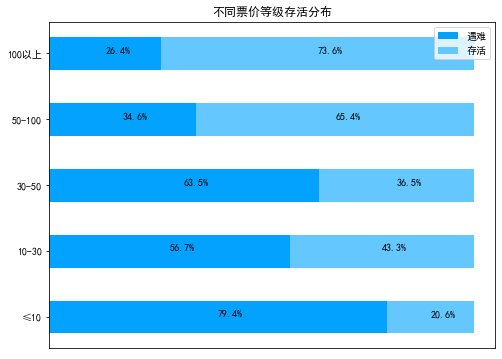

In [13]:
# 提取船票价格不为0的数据记录
fare_df=full.loc[full['Fare']>0,['Survived','Fare']]

#先来看下遇难/存活人员的平均票价
print(fare_df.groupby('Survived')['Fare'].mean())

#对票价分级
bins=[0,10,30,50,100,513]
labels=['≤10','10-30','30-50','50-100','100以上']
fare_df['level']=pd.cut(fare_df['Fare'],bins=bins,labels=labels)

# 按是否存活和票价等级分组
fare_df=fare_df.groupby(['Survived','level']).size()

# 转化成DataFrame
fare_df=fare_df.unstack()
fare_df=fare_df.rename(index={0:'遇难',1:'存活'})

# 计算占比情况
fare_prod=fare_df/fare_df.sum()
print(fare_prod)

fig=plt.figure(figsize=(8,6))#设置画布大小
ax1=fig.add_subplot(1,1,1)#添加子图
y=range(5)
a=fare_prod.loc['遇难',:]
b=fare_prod.loc['存活',:]
ax1.barh(y,a,label='遇难',height=0.5,color='#03A2FF')
ax1.barh(y,b,left=a,label='存活',height=0.5,color='#64C8FF')#通过left参数绘制堆积柱状图
ax1.set_yticks(range(5))#设置y轴刻度
ax1.set_yticklabels(['≤10','10-30','30-50','50-100','100以上'])#设置y轴刻度标签名称
ax1.set_xticks([])#将x轴刻度设置为空
ax1.legend(['遇难','存活'],loc='upper right')#设置图例名称及位置（upper/center/lower,left/center/right）
ax1.set_title('不同票价等级存活分布')#设置标题
#添加数据标签
for x,y,z in zip(range(5),a,b):
    ax1.text(y/2,x,'{:.1%}'.format(y))
    ax1.text(y+z/2,x,'{:.1%}'.format(z))

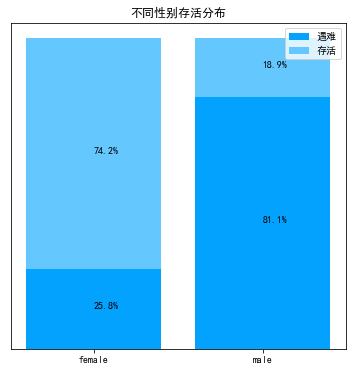

In [14]:
#按生存情况和性别分组
sex_df=full.groupby(['Survived','Sex']).size()

#进一步将数据转化成DataFrame
sex_df=sex_df.unstack('Sex')
sex_df=sex_df.rename(index={0:'遇难',1:'存活'})

sex_prod=sex_df/sex_df.sum()

fig=plt.figure(figsize=(6,6))#设置画布大小
ax1=fig.add_subplot(1,1,1)#添加子图
x=range(2)
a=sex_prod.loc['遇难',:]
b=sex_prod.loc['存活',:]
ax1.bar(x,a,label='遇难',color='#03A2FF')
ax1.bar(x,b,bottom=a,label='存活',color='#64C8FF')#通过bottom参数绘制堆积柱状图
ax1.set_xticks(range(2))#设置x轴刻度
ax1.set_xticklabels(['female','male'])#设置x轴刻度标签名称
ax1.set_yticks([])
ax1.legend(['遇难','存活'],loc='upper right')#设置图例名称及位置（upper/center/lower,left/center/right）
ax1.set_title('不同性别存活分布')#设置标题
#添加数据标签
for x,y,z in zip(range(2),a,b):
    ax1.text(x,y/2,'{:.1%}'.format(y))
    ax1.text(x,y+z/2,'{:.1%}'.format(z))

In [15]:
# 测试集里没有生存情况的值，不能用于评估模型，用做预测数据集
# 从训练集里拆分出模型训练和模型评估的数据集
# 原始数据集有891行
sourceRow = 891
source_X = full_x.loc[0:sourceRow-1, :]
source_y = full.loc[0:sourceRow-1, 'Survived']
pred_X = full_x.loc[sourceRow:, :]
print('原始数据集：', source_X.shape[0])
print('预测数据集：', pred_X.shape[0])

原始数据集： 891
预测数据集： 418


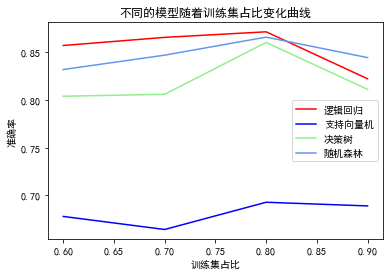

In [16]:
#建立模型用的训练数据集和测试数据集

size=np.arange(0.6,1,0.1)
scorelist=[[],[],[],[]]
for i in range(0,4):
    train_X, test_X, train_y, test_y = train_test_split(source_X ,
                                                        source_y,
                                                      train_size=size[i],
                                                        random_state=5)
    #逻辑回归
    lr_model = LogisticRegression()
    lr_model.fit( train_X , train_y )
    scorelist[0].append(lr_model.score(test_X , test_y ))
    
    #支持向量机Support Vector Machines
    svc_model = SVC()
    svc_model.fit( train_X , train_y )
    scorelist[1].append(svc_model.score(test_X , test_y ))

    #决策树
    dtc_model = DecisionTreeClassifier()
    dtc_model.fit( train_X , train_y )
    scorelist[2].append(dtc_model.score(test_X , test_y ))
    
    #随机森林Random Forests Model
    rfc_model = RandomForestClassifier(n_estimators=100)
    rfc_model.fit( train_X , train_y )
    scorelist[3].append(rfc_model.score(test_X , test_y ))

    # 分类问题，score得到的是模型的正确率
    #print(model.score(test_X , test_y ))

color_list = ('red', 'blue', 'lightgreen', 'cornflowerblue')
for i in range(0,4):
    plt.plot(size,scorelist[i],color=color_list[i])
plt.legend(['逻辑回归','支持向量机', '决策树', '随机森林'])

plt.xlabel('训练集占比')
plt.ylabel('准确率')
plt.title('不同的模型随着训练集占比变化曲线')
plt.show()

In [17]:
lr_y_predict = lr_model.predict(pred_X)
lr_submission = pd.DataFrame({'PassengerId': test['PassengerId'], 'Survived': lr_y_predict})
lr_submission.to_csv('lr_submission.csv', index=False)

In [18]:
# 使用并行网格搜索的方式寻找更好的超参数组合，进一步提高XGBClassifier的预测性能
'''
params = {'max_depth': range(2, 7), 'n_estimators': range(100, 1100, 200), 'learning_rate': [0.05, 0.1, 0.25, 0.5, 1.0]}
xgbc_best = XGBClassifier()
gs = GridSearchCV(xgbc_best, params, n_jobs=-1, cv=5, verbose=1)
gs.fit(train_X, train_y)

print('gs====================')
print(gs.best_score_) 
print(gs.best_params_)  

xgbc_best_y_predict = gs.predict(pred_X)
xgbc_best_submission = pd.DataFrame({'PassengerId': test['PassengerId'], 'Survived': xgbc_best_y_predict})
xgbc_best_submission.to_csv('xgbc_best_submission.csv', index=False)
'''

"\nparams = {'max_depth': range(2, 7), 'n_estimators': range(100, 1100, 200), 'learning_rate': [0.05, 0.1, 0.25, 0.5, 1.0]}\nxgbc_best = XGBClassifier()\ngs = GridSearchCV(xgbc_best, params, n_jobs=-1, cv=5, verbose=1)\ngs.fit(train_X, train_y)\n\nprint('gs====================')\nprint(gs.best_score_) \nprint(gs.best_params_)  \n\nxgbc_best_y_predict = gs.predict(pred_X)\nxgbc_best_submission = pd.DataFrame({'PassengerId': test['PassengerId'], 'Survived': xgbc_best_y_predict})\nxgbc_best_submission.to_csv('xgbc_best_submission.csv', index=False)\n"